In [1]:
#matplotlib
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import basic modules
import time
import matplotlib.pyplot as plt

In [3]:
#copy CANA datasets into this directory if the package fails to install (package requires Microsoft Visual C++)
#import cana
from cana.boolean_node import *
from cana.boolean_network import *

In [4]:
#import scripts
from utils import *
from modules import *
import mean_field_computations
from mean_field_computations import *
from brute_force_computations import *
from simulations import *
from entropy_computations import *
from driver_sets import *

#### Run simulator from the IM repo

In [12]:
N=BooleanNetwork.from_file('leukemia.txt',file_type='logical') #may be any file in logical form

In [13]:
#reduce the look-up-table and find all sunits (i.e. node states) in the network
dd={node.name: LUT_reduce(look_up_table(node)) for node in N.nodes}
nodes=dd.keys()
print(len(dd),nodes)
modules,translator={},{}
sunits,sunit_map=get_sunits(N)
print(len(sunits),sunit_map)

60 ['TAX', 'FasT', 'FYN', 'SPHK1', 'FLIP', 'PLCG1', 'DISC', 'TPL2', 'Stimuli2', 'ERK', 'Proliferation', 'STAT3', 'IL2RBT', 'Fas', 'BID', 'TCR', 'Caspase', 'TRADD', 'GAP', 'CD45', 'GPCR', 'PDGF', 'ZAP70', 'FasL', 'IL15', 'SOCS', 'RAS', 'P2', 'CTLA4', 'sFas', 'Cytoskeleton_signaling', 'PI3K', 'IFNG', 'Stimuli', 'S1P', 'PDGFR', 'TNF', 'JAK', 'SMAD', 'IFNGT', 'BclxL', 'IAP', 'NFAT', 'A20', 'IL2RA', 'IL2RB', 'GZMB', 'NFKB', 'Ceramide', 'TBET', 'MEK', 'P27', 'GRB2', 'IL2', 'Apoptosis', 'CREB', 'RANTES', 'LCK', 'IL2RAT', 'MCL1']
120 {0: 'CTLA4-0', 1: 'CTLA4-1', 2: 'TCR-0', 3: 'TCR-1', 4: 'PDGFR-0', 5: 'PDGFR-1', 6: 'FYN-0', 7: 'FYN-1', 8: 'Cytoskeleton_signaling-0', 9: 'Cytoskeleton_signaling-1', 10: 'LCK-0', 11: 'LCK-1', 12: 'ZAP70-0', 13: 'ZAP70-1', 14: 'GRB2-0', 15: 'GRB2-1', 16: 'PLCG1-0', 17: 'PLCG1-1', 18: 'RAS-0', 19: 'RAS-1', 20: 'GAP-0', 21: 'GAP-1', 22: 'MEK-0', 23: 'MEK-1', 24: 'ERK-0', 25: 'ERK-1', 26: 'PI3K-0', 27: 'PI3K-1', 28: 'NFKB-0', 29: 'NFKB-1', 30: 'NFAT-0', 31: 'NFAT-1',

In [177]:
# seed=[108, 111, 113, 114, 116, 118] # seed nodes for pro-oncogenic bi-stable state
seed = [108]
for node in seed:
    print(sunit_map[node])

PDGF-0


In [178]:
# synchronous_mf(N,sunit_map, )
# def synchronous_mf(N,act_nodes,act_prob,iterations=10,pinning=set([]),reduced=False,ds=None,pin_start=True):
# reload(mean_field_computations)
# from mean_field_computations import *
seed=seed
iterations=20
IBMFA = run_seed_mf(N,seed,sunit_map,translator,p=0.5,iterations=iterations,pinning=set([]),reduced=False,ds=None,pin_start=True,
            update='asynchronous',order=None,regenerate=False,oh=False,names='string')
# def run_seed_mf(N,seed,sunit_map,translator,p=0.5,iterations=10,pinning=set([]),reduced=False,ds=None,pin_start=True,
#             update='synchronous',order=None,regenerate=False,oh=False,names='string'):

In [179]:
print(sorted([(n,v) for n,v in IBMFA[iterations].items()],key=lambda x: x[0],reverse=False))


[('A20', 0.8671328625808146), ('Apoptosis', 0.9987299925799175), ('BID', 0.9960565897204424), ('BclxL', 3.280208039562572e-08), ('CD45', 0.5), ('CREB', 0.13401162213978499), ('CTLA4', 0.33333349227905273), ('Caspase', 0.9987299925799175), ('Ceramide', 0.8420356108099942), ('Cytoskeleton_signaling', 0.4226656297416036), ('DISC', 0.8281928087579251), ('ERK', 0.26802142683459707), ('FLIP', 0.15051732795373846), ('FYN', 0.42273420342429036), ('Fas', 0.8420357124097921), ('FasL', 0.9709939924872766), ('FasT', 0.867192360802474), ('GAP', 0.2589253623366354), ('GPCR', 1.09935518884463e-07), ('GRB2', 0.4510406918537204), ('GZMB', 0.9999673696370138), ('IAP', 0.0034196952699422816), ('IFNG', 0.5000023262139103), ('IFNGT', 0.999989568660103), ('IL15', 0.5), ('IL2', 5.429758949410267e-05), ('IL2RA', 4.37463987467937e-09), ('IL2RAT', 4.983468484414736e-05), ('IL2RB', 0.13410109869004977), ('IL2RBT', 0.26801205263971384), ('JAK', 0.38138637652138874), ('LCK', 0.6340017151485561), ('MCL1', 0.0039432

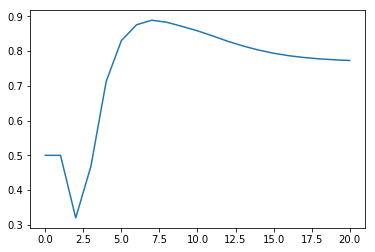

In [144]:
plt.plot([IBMFA[time]['Apoptosis'] for time in IBMFA])

### Single node interventions

In [109]:
single_node_interventions = {}
for node in sunit_map.keys():
    # print(node)
    seed = [node]
    iterations=20
    IBMFA_temp = run_seed_mf(N,seed,sunit_map,translator,p=0.5,iterations=iterations,pinning=set([]),reduced=False,ds=None,pin_start=True,
            update='asynchronous',order=None,regenerate=False,oh=False,names='string')
#     print(sorted([(n,v) for n,v in IBMFA_temp[iterations].items()],key=lambda x: x[0],reverse=False))
    print(node)
    single_node_interventions[node] = IBMFA_temp

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


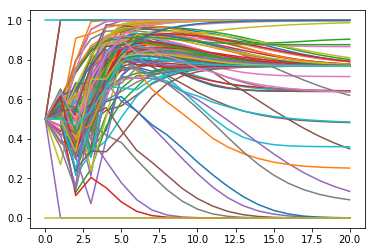

In [110]:
for node in single_node_interventions.keys():
    plt.plot([single_node_interventions[node][time]['Apoptosis'] for time in single_node_interventions[node]])

In [145]:
select_seeds = [108, 111, 113, 114, 116, 118]

In [146]:
select_single_node_interventions = {}
for node in select_seeds:
    # print(node)
    seed = [node]
    iterations=20
    IBMFA_temp = run_seed_mf(N,seed,sunit_map,translator,p=0.5,iterations=iterations,pinning=set([]),reduced=False,ds=None,pin_start=True,
            update='asynchronous',order=None,regenerate=False,oh=False,names='string')
#     print(sorted([(n,v) for n,v in IBMFA_temp[iterations].items()],key=lambda x: x[0],reverse=False))
    print(node, sunit_map[node])
    select_single_node_interventions[node] = IBMFA_temp

(108, 'PDGF-0')
(111, 'IL15-1')
(113, 'Stimuli-1')
(114, 'Stimuli2-0')
(116, 'CD45-0')
(118, 'TAX-0')


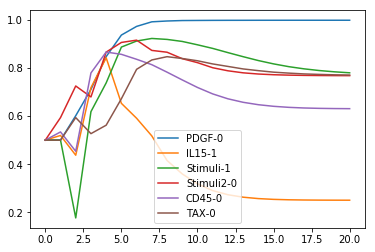

In [118]:
for node in select_single_node_interventions.keys():
    plt.plot([select_single_node_interventions[node][time]['Apoptosis'] for time in select_single_node_interventions[node]], label = sunit_map[node])

plt.legend()

In [124]:
seed = [108]
print(select_seeds+seed)

[108, 111, 113, 114, 116, 118, 108]


## Set context (bistable context) single node intervetions

In [128]:
bistable_context_seed = [108, 111, 113, 114, 116, 118]

In [129]:
bistable_context_single_node_interventions = {}
for node in sunit_map.keys():
    # print(node)
    seed = bistable_context_seed + [node]
    iterations=20
    IBMFA_temp = run_seed_mf(N,seed,sunit_map,translator,p=0.5,iterations=iterations,pinning=set([]),reduced=False,ds=None,pin_start=True,
            update='asynchronous',order=None,regenerate=False,oh=False,names='string')
#     print(sorted([(n,v) for n,v in IBMFA_temp[iterations].items()],key=lambda x: x[0],reverse=False))
    print(seed)
    bistable_context_single_node_interventions[node] = IBMFA_temp

[108, 111, 113, 114, 116, 118, 0]
[108, 111, 113, 114, 116, 118, 1]
[108, 111, 113, 114, 116, 118, 2]
[108, 111, 113, 114, 116, 118, 3]
[108, 111, 113, 114, 116, 118, 4]
[108, 111, 113, 114, 116, 118, 5]
[108, 111, 113, 114, 116, 118, 6]
[108, 111, 113, 114, 116, 118, 7]
[108, 111, 113, 114, 116, 118, 8]
[108, 111, 113, 114, 116, 118, 9]
[108, 111, 113, 114, 116, 118, 10]
[108, 111, 113, 114, 116, 118, 11]
[108, 111, 113, 114, 116, 118, 12]
[108, 111, 113, 114, 116, 118, 13]
[108, 111, 113, 114, 116, 118, 14]
[108, 111, 113, 114, 116, 118, 15]
[108, 111, 113, 114, 116, 118, 16]
[108, 111, 113, 114, 116, 118, 17]
[108, 111, 113, 114, 116, 118, 18]
[108, 111, 113, 114, 116, 118, 19]
[108, 111, 113, 114, 116, 118, 20]
[108, 111, 113, 114, 116, 118, 21]
[108, 111, 113, 114, 116, 118, 22]
[108, 111, 113, 114, 116, 118, 23]
[108, 111, 113, 114, 116, 118, 24]
[108, 111, 113, 114, 116, 118, 25]
[108, 111, 113, 114, 116, 118, 26]
[108, 111, 113, 114, 116, 118, 27]
[108, 111, 113, 114, 116, 118,

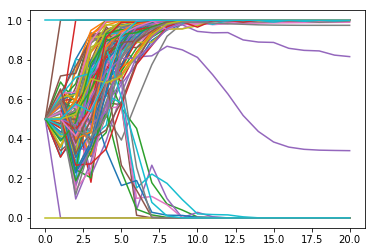

In [130]:
for node in bistable_context_single_node_interventions.keys():
    plt.plot([bistable_context_single_node_interventions[node][time]['Apoptosis'] for time in bistable_context_single_node_interventions[node]])

In [131]:
import pandas as pd

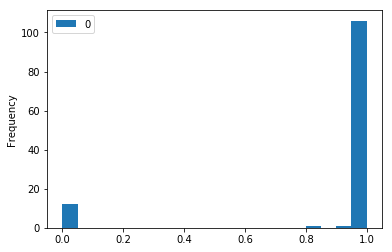

In [139]:
# Plot histogram of Apoptosis values for the last time point for each node

df_results = pd.DataFrame([bistable_context_single_node_interventions[node][10]['Apoptosis'] for node in bistable_context_single_node_interventions.keys()])

df_results.plot.hist(bins=20)
